In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from deap import base, creator, tools, algorithms
from scipy import stats

In [35]:
df = pd.read_csv('dev_train.csv')
df = df[df.columns[2:]]
df.columns = [i.strip() for i in df.columns]

In [36]:
Y = df[df.columns[0]]
X = df[df.columns[1:]]

# Plan projektu:
- Feature engineering
    - Principal component analysis (PCA)
    - Polynomial features
- Normalization (normal distribution)
- Resampling (bootstrapping)
- Feature selection
    - t-testing
    - Recursive feature elimination (RFE)
    - Sequential Feature Selector with forward selection
    - Genetic algorithm(*)
- Modeling
    - Logistic regression
    - Decision tree classifier
    - Random forest classifier
    - Gradient boosting classifier
    - C-Support vector classification
- Wnioski

# Feature engineering

### Principal component analysis (PCA)

In [37]:
n_components = len(X.columns)
pca = PCA(n_components=n_components)
pca.fit(X)
evr = pca.explained_variance_ratio_

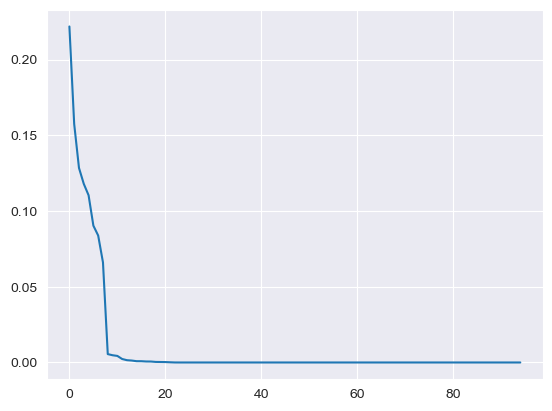

In [38]:
plt.plot(evr)

[]

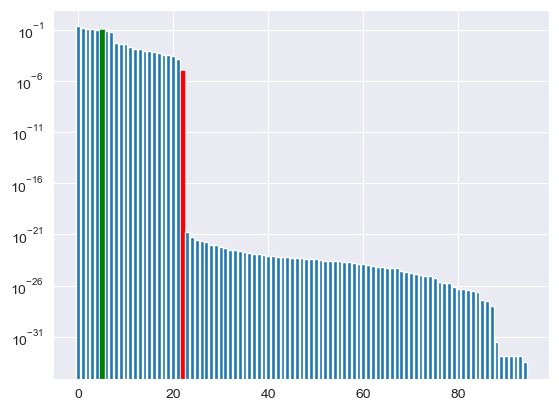

In [179]:
bars = plt.bar(range(n_components), evr)
bars[22].set_color('r')
bars[5].set_color('g')
plt.semilogy()

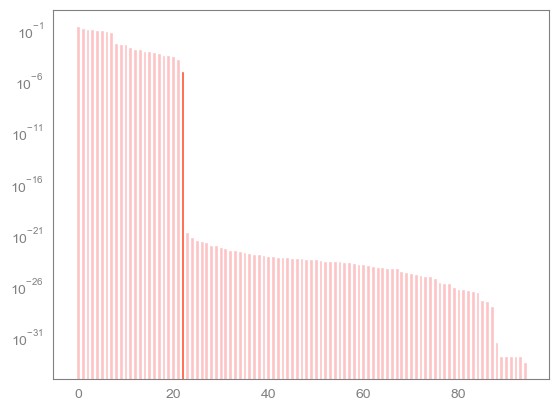

In [190]:
color = ['#FDC3C5' for i in range(22)] + ['#FE502D'] + ['#FDC3C5' for i in range(23, n_components)]

fig, ax = plt.subplots()
ax.bar(range(n_components), evr,
       color=color)
plt.yscale('log')

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.tick_params(colors='grey', which='both')
for spine in ax.spines.values():
    spine.set_color('grey')

ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

plt.savefig('barplot.png')

In [40]:
pca22 = PCA(n_components=23)
X_pca = pca22.fit_transform(X)

In [177]:
X_pca

array([[-1.71745791e+09, -4.42771193e+07, -4.10167517e+08, ...,
        -4.95511087e+06,  1.00336386e+08, -3.26316724e+05],
       [-3.06605147e+09, -1.66818999e+09, -2.07581122e+09, ...,
        -4.90860157e+05, -1.61259191e+07, -2.32295494e+05],
       [-1.09299068e+09,  9.63484763e+08,  8.76971832e+09, ...,
         1.70765745e+06, -1.22913470e+07,  1.72237784e+05],
       ...,
       [-2.99028313e+09, -3.33126492e+09, -3.56573555e+09, ...,
        -1.01686075e+06, -1.61820155e+07, -3.00932951e+05],
       [ 6.99037411e+09,  4.30514036e+09,  5.58039860e+09, ...,
         5.07342457e+06, -2.01446823e+07,  3.33822549e+05],
       [-2.70156157e+09, -2.64330497e+09, -1.50255916e+09, ...,
        -4.46637067e+06, -1.96431007e+07, -9.71197686e+05]])

### Polynomial Features

In [100]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_pca)

In [101]:
X_poly

array([[-1.71745791e+09, -4.42771193e+07, -4.10167517e+08, ...,
        -4.97177918e+14,  1.61693555e+12, -3.27414408e+13],
       [-3.06605147e+09, -1.66818999e+09, -2.07581122e+09, ...,
         7.91557118e+12,  1.14024603e+11,  3.74597835e+12],
       [-1.09299068e+09,  9.63484763e+08,  8.76971832e+09, ...,
        -2.09894103e+13,  2.94123136e+11, -2.11703437e+12],
       ...,
       [-2.99028313e+09, -3.33126492e+09, -3.56573555e+09, ...,
         1.64548563e+13,  3.06006905e+11,  4.86970167e+12],
       [ 6.99037411e+09,  4.30514036e+09,  5.58039860e+09, ...,
        -1.02202526e+14,  1.69362352e+12, -6.72474919e+12],
       [-2.70156157e+09, -2.64330497e+09, -1.50255916e+09, ...,
         8.77333686e+13,  4.33772886e+12,  1.90773339e+13]])

# Normalization - normal distribution

In [102]:
X_norm = pd.DataFrame(StandardScaler().fit_transform(X_poly), columns=[f'feature{i}' for i in range(X_poly.shape[1])])
X_norm.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275
0,-0.430445,-0.013172,-0.135110,2.705285,0.663174,1.335335,-0.692008,0.097092,-0.095865,0.096697,...,0.041856,-0.038648,0.036074,-0.021398,-0.028854,0.433642,-0.000395,-0.034862,0.010489,-0.115041
1,-0.768442,-0.496286,-0.683779,-1.368245,0.630795,-0.618583,-0.315916,-0.083980,-0.144572,-0.107290,...,0.017052,0.001493,0.002261,0.005941,0.002986,0.072801,0.000294,0.000555,0.000740,0.013162
2,-0.273935,0.286636,2.888772,-0.747581,-0.141286,1.813917,-0.509431,0.628108,0.062937,0.005001,...,-0.010160,0.019327,-0.006412,0.016388,-0.001664,0.008887,-0.000035,-0.001472,0.001908,-0.007438
3,-0.754201,-0.986657,-1.180946,-1.357351,0.594366,-0.462327,-0.379682,-0.303458,-0.180877,-0.131389,...,0.024686,0.004416,0.003254,0.013887,0.005925,0.070296,0.000461,0.001095,0.002370,0.020521
4,0.294102,-1.086139,1.401105,0.627331,0.481721,-0.608380,-0.072590,-0.089051,-0.118920,-0.085747,...,0.008184,-0.001929,-0.002354,-0.013975,-0.001278,-0.025118,-0.000229,0.000516,0.001552,0.022258


# Resampling - bootstrapping

In [103]:
how_many_more = Y.value_counts()[0] - Y.value_counts()[1]
bankrupt_true = np.where(Y == 1, True, False).tolist()
bankrupt_index = Y.loc[bankrupt_true].index.tolist()
additional_samples = np.random.choice(bankrupt_index, how_many_more).tolist()
total_index = Y.index.tolist() + additional_samples 

In [104]:
Y_resampl = Y.loc[total_index]
X_resampl = X_norm.loc[total_index]

In [105]:
Y_resampl.value_counts()

Bankrupt?
0    3220
1    3220
Name: count, dtype: int64

# Feature selection

### T-testing

In [107]:
df_resampl = copy.copy(X_resampl)
df_resampl['Bankrupt?'] = Y_resampl

cols_to_test = X_resampl.columns.tolist()

def t_test_for_feature(feature, df):
    group1 = df[df['Bankrupt?'] == 0][feature]
    group2 = df[df['Bankrupt?'] == 1][feature]
    t_stat, p_val = stats.ttest_ind(group1, group2)
    print(f"T-statistic for {feature}: {t_stat}, P-value: {p_val}")
    return p_val <= 0.05

smaller_p_vals_than_alpha = [t_test_for_feature(f, df_resampl) for f in cols_to_test]
X_t_test = X_resampl.loc[:, smaller_p_vals_than_alpha]

pd.Series(smaller_p_vals_than_alpha).value_counts()

T-statistic for feature0: -1.6300735530857497, P-value: 0.10313487177003137
T-statistic for feature1: 0.5152348328562538, P-value: 0.6064066209390491
T-statistic for feature2: 6.917399849470144, P-value: 5.044092058150729e-12
T-statistic for feature3: 14.661089243183476, P-value: 6.72802470276034e-48
T-statistic for feature4: 0.4334695436880974, P-value: 0.664688210483006
T-statistic for feature5: 3.717899250772096, P-value: 0.00020259248451829221
T-statistic for feature6: -14.911493856365738, P-value: 1.8435635520667017e-49
T-statistic for feature7: 2.521767755054191, P-value: 0.011700606940915783
T-statistic for feature8: 0.5561684918703033, P-value: 0.57811500518059
T-statistic for feature9: -9.15748515202018, P-value: 7.008703096720295e-20
T-statistic for feature10: -4.345887305247508, P-value: 1.4084710324738691e-05
T-statistic for feature11: 5.093481752406109, P-value: 3.6154659299856474e-07
T-statistic for feature12: -0.31318601458439593, P-value: 0.7541494882725347
T-statistic 

True     159
False    117
Name: count, dtype: int64

In [108]:
X_t_test.head()

,feature2,feature3,feature5,feature6,feature7,feature9,feature10,feature11,feature13,feature14,...,feature261,feature263,feature264,feature266,feature267,feature268,feature269,feature270,feature273,feature274
0,-0.135110,2.705285,1.335335,-0.692008,0.097092,0.096697,-0.221408,0.091250,0.017187,0.023478,...,0.018597,-0.000802,0.236601,0.041856,-0.038648,0.036074,-0.021398,-0.028854,-0.034862,0.010489
1,-0.683779,-1.368245,-0.618583,-0.315916,-0.083980,-0.107290,-0.033205,-0.199026,-0.085052,-0.033983,...,0.029952,0.000328,0.157025,0.017052,0.001493,0.002261,0.005941,0.002986,0.000555,0.000740
2,2.888772,-0.747581,1.813917,-0.509431,0.628108,0.005001,-0.213324,0.029266,0.083640,0.022673,...,0.096966,0.000994,-0.104147,-0.010160,0.019327,-0.006412,0.016388,-0.001664,-0.001472,0.001908
3,-1.180946,-1.357351,-0.462327,-0.379682,-0.303458,-0.131389,-0.030699,-0.200541,-0.104518,-0.045135,...,0.046089,0.000692,0.161162,0.024686,0.004416,0.003254,0.013887,0.005925,0.001095,0.002370
4,1.401105,0.627331,-0.608380,-0.072590,-0.089051,-0.085747,-0.122453,0.002843,-0.017031,-0.044972,...,-0.005752,0.000056,0.021678,0.008184,-0.001929,-0.002354,-0.013975,-0.001278,0.000516,0.001552


### Recursive feature elimination - RFE

In [125]:
model = LogisticRegression(max_iter=1000)
rfe = feature_selection.RFE(estimator=model, n_features_to_select=40)
rfe.fit(X_t_test, Y_resampl)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=40)

In [128]:
X_rfe = pd.DataFrame(rfe.transform(X_t_test), columns=rfe.get_feature_names_out().tolist())
X_rfe.head()

,feature10,feature11,feature13,feature16,feature17,feature20,feature21,feature51,feature53,feature62,...,feature195,feature226,feature227,feature228,feature232,feature252,feature257,feature258,feature270,feature274
0,-0.221408,0.091250,0.017187,0.029604,0.025935,-0.035235,1.024266,0.001512,0.002791,-0.005204,...,-0.000928,-0.016953,-0.025829,0.000049,0.000772,-0.002863,0.008616,-0.014217,-0.028854,0.010489
1,-0.033205,-0.199026,-0.085052,-0.104908,-0.107098,-0.003490,-0.164618,0.085914,0.015773,0.204807,...,0.000102,0.027048,0.110371,0.000020,0.020253,0.001503,0.031895,0.004991,0.002986,0.000740
2,-0.213324,0.029266,0.083640,0.063375,0.093193,0.012143,-0.125474,0.021601,-0.058526,-0.018944,...,0.000017,0.115521,-0.020292,0.000079,0.024611,0.006463,-0.003086,0.010489,-0.001664,0.001908
3,-0.030699,-0.200541,-0.104518,-0.124937,-0.112193,-0.007028,-0.161282,0.213697,0.028991,0.401299,...,0.000251,0.044686,0.122348,0.000045,0.029326,0.003567,0.037437,0.011967,0.005925,0.002370
4,-0.122453,0.002843,-0.017031,-0.018975,-0.017090,-0.003747,-0.142419,0.154663,0.127300,-0.178755,...,0.000087,-0.036166,-0.048905,0.000024,0.001816,0.000723,-0.002301,0.000969,-0.001278,0.001552


### Sequential Feature Selector with forward selection

In [132]:
knn = KNeighborsClassifier(n_neighbors=5)
sfs = feature_selection.SequentialFeatureSelector(knn)
sfs.fit(X_rfe, Y_resampl)

SequentialFeatureSelector(estimator=KNeighborsClassifier())

In [133]:
X_sfs = pd.DataFrame(sfs.transform(X_rfe), columns=sfs.get_feature_names_out().tolist())
X_sfs.head()

,feature11,feature13,feature16,feature76,feature79,feature93,feature109,feature114,feature120,feature182,feature186,feature195,feature226,feature228,feature232,feature252,feature257,feature258,feature270,feature274
0,0.091250,0.017187,0.029604,-0.002808,-0.005216,0.153223,0.063860,0.020410,-0.031894,0.007178,0.008946,-0.000928,-0.016953,0.000049,0.000772,-0.002863,0.008616,-0.014217,-0.028854,0.010489
1,-0.199026,-0.085052,-0.104908,0.070322,0.093549,0.169026,-0.067396,-0.028101,-0.003005,0.001072,0.021649,0.000102,0.027048,0.000020,0.020253,0.001503,0.031895,0.004991,0.002986,0.000740
2,0.029266,0.083640,0.063375,0.292158,0.238752,-0.013580,-0.000704,-0.004199,-0.002342,0.001624,0.000148,0.000017,0.115521,0.000079,0.024611,0.006463,-0.003086,0.010489,-0.001664,0.001908
3,-0.200541,-0.104518,-0.124937,0.149249,0.192413,0.168956,-0.077768,-0.035166,-0.005702,0.002702,0.026714,0.000251,0.044686,0.000045,0.029326,0.003567,0.037437,0.011967,0.005925,0.002370
4,0.002843,-0.017031,-0.018975,-0.028854,-0.034672,0.001107,-0.041134,-0.028399,-0.002464,0.000947,-0.000247,0.000087,-0.036166,0.000024,0.001816,0.000723,-0.002301,0.000969,-0.001278,0.001552


### Genetic algorithm

In [144]:
creator.create("FeatureSelect", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FeatureSelect)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X_sfs.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalFeatures(individual):
    features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(features) == 0:
        return 0,
    X_selected = X_sfs.iloc[:, features]
    estimator = LogisticRegression(max_iter=1000)
    scores = cross_val_score(estimator, X_selected, Y_resampl, cv=5)
    return np.mean(scores),

toolbox.register("evaluate", evalFeatures)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
toolbox.register("select", tools.selRoulette)
toolbox.register("population_guess", tools.initRepeat, list, toolbox.individual)

# parameters
population_size = 120
crossover_prob = 0.7
mutation_prob = 0.1
n_generations = 40
elite_size = 30

def main():
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(elite_size)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=n_generations,
                        stats=stats, halloffame=hof, verbose=True)

    best_ind = hof[0]
    best_features = [i for i, bit in enumerate(best_ind) if bit == 1]
    print("Best Individual = ", best_ind)
    print("Selected Features = ", best_features)
    return pop, stats, hof

if __name__ == "__main__":
    final_population, statistics, hall_of_fame = main()

    best_ind = hall_of_fame[0]
    best_features_indices = [i for i, bit in enumerate(best_ind) if bit == 1]
    best_features_names = X_sfs.columns[best_features_indices]  # Directly access the column names
    
    X_ga = X_sfs[best_features_names]

C:\Users\olly\AppData\Local\r-miniconda\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FeatureSelect' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\olly\AppData\Local\r-miniconda\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     
0  	120   	0.571316	0.524689	0.614286
1  	81    	0.572968	0.521739	0.614286
2  	73    	0.577393	0.521739	0.618478
3  	89    	0.580056	0.528727	0.618478
4  	78    	0.583762	0.528416	0.618478
5  	80    	0.583199	0.528571	0.618478
6  	79    	0.584011	0.526553	0.618478
7  	86    	0.584031	0.529193	0.614441
8  	87    	0.583579	0.529193	0.614441
9  	100   	0.584658	0.524689	0.615373
10 	82    	0.586425	0.524689	0.616149
11 	83    	0.585657	0.52764 	0.614907
12 	90    	0.583445	0.52764 	0.614907
13 	97    	0.583526	0.530124	0.614907
14 	87    	0.583398	0.529348	0.614907
15 	89    	0.582791	0.526398	0.61646 
16 	83    	0.58234 	0.529348	0.617547
17 	88    	0.583966	0.529814	0.620342
18 	82    	0.583628	0.529814	0.620342
19 	98    	0.582338	0.530901	0.616149
20 	80    	0.581985	0.523292	0.61646 
21 	85    	0.578789	0.523292	0.615062
22 	82    	0.579728	0.511646	0.618323
23 	86    	0.577703	0.528261	0.614286
24 	84    	0.578837	0.528261	0.614907
25 	90    	0

Powyższy algorytm jest bardzo skomplikowany, dlatego poprawne ustawienie parametrów zajmuje bardzo dużo czasu. Zostawiamy jako ciekawostkę - nie wnosi nic do projektu :)

# Modeling with cross validation

In [158]:
X_new = X_sfs
Y_new = Y_resampl

### Logistic regression

In [171]:
clf_lr = LogisticRegression(random_state=0, max_iter=1000)
scores_lr = cross_val_score(clf_lr, X_new, Y_new, cv=5)
np.mean(scores_lr)

0.5899068322981366

### Decision tree classifier

In [172]:
clf_dt = tree.DecisionTreeClassifier()
scores_dt = cross_val_score(clf_dt, X_new, Y_new, cv=5)
np.mean(scores_dt)

0.9804347826086957

### Random forest classifier

In [173]:
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
scores_rf = cross_val_score(clf_rf, X_new, Y_new, cv=5)
np.mean(scores_rf)

0.699223602484472

### Gradient boosting classifier

In [174]:
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
scores_gb = cross_val_score(clf_gb, X_new, Y_new, cv=5)
np.mean(scores_gb)

0.896583850931677

### C-Support Vector Classification

In [175]:
clf_svc = SVC(kernel='linear', C=1, random_state=42)
scores_svc = cross_val_score(clf_svc, X_new, Y_new, cv=5)
np.mean(scores_svc)

0.6054347826086957

# Wnioski

Rozpoczęłyśmy naszą pracę nad projektem od inżynierii cech, co pozwoliło nam na redukcję wymiarowości przestrzeni naszych danych. Kolejnym krokiem było zastosowanie metody Polynomial Features, jako dodatkowej techniki preprocessingu. Dzięki temu uzyskałyśmy ponad 250 kolumn, co wymagało dalszej selekcji cech w celu ograniczenia ich liczby. W tym celu wykorzystałyśmy metody takie jak t-testing, rekurencyjna eliminacja cech (Recursive Feature Elimination) oraz sekwencyjny selektor cech z selekcją w przód (Feature Selector with forward selection), co pozwoliło nam ostatecznie skoncentrować się na 20 najbardziej istotnych cechach, które zostaną wykorzystane w dalszym modelowaniu.

Ostatnim etapem było wstępne modelowanie, w ramach którego zastosowałyśmy proste modele klasyfikacyjne, takie jak regresja logistyczna, drzewa decyzyjne, lasy losowe, gradient boosting oraz klasyfikacja wektorów nośnych z jądrem liniowym (C-Support Vector Classification). Do oceny wydajności tych modeli wykorzystałyśmy technikę walidacji krzyżowej (cross validation), co pozwoliło nam na obliczenie score i porównanie wyników.

Wnioski z naszego projektu pokazują, że starannie przeprowadzona inżynieria cech oraz dokładna selekcja modeli może znacząco wpłynąć na efektywność klasyfikacji w zadaniach predykcyjnych. Porównanie różnych modeli pozwoliło na wyciągnięcie wniosków dotyczących ich skuteczności i zastosowania w kontekście przewidywania upadłości.

In [11]:
X = np.arange(15).reshape(3, 5)
X

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [14]:
poly = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)

In [15]:
poly.fit_transform(X)

array([[  0.,   1.,   2.,   3.,   4.,   0.,   0.,   0.,   0.,   2.,   3.,
          4.,   6.,   8.,  12.],
       [  5.,   6.,   7.,   8.,   9.,  30.,  35.,  40.,  45.,  42.,  48.,
         54.,  56.,  63.,  72.],
       [ 10.,  11.,  12.,  13.,  14., 110., 120., 130., 140., 132., 143.,
        154., 156., 168., 182.]])